# Solving the Traveling Salesman Problem with DWave's Hybrid Optimization

**Filipe Chagas Ferraz**

The **Traveling Salesman Problem (TSP)** is a classic optimization problem in the field of combinatorial optimization and operations research. It involves a salesman who must visit a set of $N$ cities, starting and ending at the same city, while visiting each city exactly once. The objective is to find the shortest possible route that allows the salesman to complete the tour.

Formally, the TSP can be described as a graph-based problem, where each city represents a node, and each path between two cities has an associated cost or distance. The goal is to find the Hamiltonian cycle with the minimum total cost. The problem is known to be NP-hard, meaning that there is no known efficient algorithm to solve it for large instances in polynomial time. Despite this, the TSP has wide applications in logistics, manufacturing, and even DNA sequencing, making it a fundamental challenge in optimization. Various approximation and heuristic methods, such as genetic algorithms, simulated annealing, and quantum annealing, are often used to find near-optimal solutions. In this notebook, we explore the use of the D-Wave's hybrid (quantum + classical) optimization service.

*Disclaimer: the introduction above was generated by ChatGPT.*

## Problem description

Given a set of cities $\{c_1, c_2, ..., c_N\}$, find the path $P\in\mathbb{N}^N$ (where each $P_i$ is the index of a city) that passes through all the cities with the least total travelling distance.

## Quadratic constrained binary formulation
The Travelig Salesman problem can be modeled as the following constrained quadratic optimization model:

$$x^* = \min_{x \in \mathbb{B}^{N\times N}} \left\{
    \sum_{p=2}^N \sum_{i=1}^N \sum_{j \neq i }^N d_{(i,j)} x_{(i,p)} x_{(j,p-1)} 
    + \sum_{i=1}^N \sum_{j \neq i }^N d_{(i,j)} x_{(i,0)} x_{(j,N)} \right\}, 
\quad \forall_{1 \leq i \leq N}: \sum_{p=1}^N x^*_{(i,p)} = 1, 
\quad \forall_{1 \leq p \leq N}: \sum_{i=1}^N x^*_{(i,p)} = 1$$

where:
* $x_{(i,p)} \in \mathbb{B}$ - indicates that the i-th city of the map is allocated in the p-th position of the path;
* $d_{(i,j)} \in \mathbb{R}$ - distance between i-th and j-th cities.

Once $x^*$ is found, the path $P=[P_1, P_2, ..., P_N]$ is defined as $P_p = \max_{0 \leq i \leq N} x_{(i,p)}$.


## Converting to a quadratic uncontrained Binary model (QUBO)

By default, quantum and hybrid annealers works with QUBO models. To convert the 1th equation to a QUBO model, we can transform the constraits into quadratic penalty terms $H_1(x), H_2(x)$:

$$H_1(x) = \sum_{i=1}^N \left( \sum_{p=1}^N x_{(i,p)} - 1 \right)^2 = \sum_{i=1}^N \left( \sum_{p=1}^N \sum_{q=1}^N x_{(i,p)} x_{(i,q)} - 2 \sum_{p=1}^N x_{(i,p)} + 1\right) = \sum_{i=1}^N \sum_{p=1}^N \sum_{q=1}^N x_{(i,p)}  x_{(i,q)} - 2 \sum_{i=1}^N \sum_{p=1}^N x_{(i,p)} + N$$

$$H_2(x) = \sum_{p=1}^N \left( \sum_{i=1}^N x_{(i,p)} - 1 \right)^2 = \sum_{p=1}^N \left( \sum_{i=1}^N \sum_{j=1}^N x_{(i,p)} x_{(j,p)} - 2 \sum_{i=1}^N x_{(i,p)} + 1\right) = \sum_{p=1}^N \sum_{i=1}^N \sum_{j=1}^N x_{(i,p)}  x_{(j,p)} - 2 \sum_{i=1}^N \sum_{p=1}^N x_{(i,p)} + N$$

Since the constant $N$ does not change the final result of the optimization, we can simply cut it out of the term.

$$H_1(x) = \sum_{i=1}^N \sum_{p=1}^N \sum_{q=1}^N x_{(i,p)}  x_{(i,q)} - 2 \sum_{i=1}^N \sum_{p=1}^N x_{(i,p)}$$

$$H_2(x) = \sum_{p=1}^N \sum_{i=1}^N \sum_{j=1}^N x_{(i,p)}  x_{(j,p)} - 2 \sum_{i=1}^N \sum_{p=1}^N x_{(i,p)}$$

The final objective function is:

$$L(x) = \sum_{p=2}^N \sum_{i=1}^N \sum_{j \neq i}^N d_{(i,j)} x_{(i,p)} x_{(j,p-1)} + \gamma (H_1(x) + H_2(x))$$

where $\gamma \in \mathbb{R}$ is a penalty factor.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from getpass import getpass
import dimod
from dwave.system import LeapHybridSampler
from dwave.samplers import SimulatedAnnealingSampler

The next cell defines the number of cities $N$. Increasing this number also increases the number of binary variables ($N^2$).

In [2]:
N = 10 # Number of cities

In the next cell, a pair of random $(x_i,y_i)$ coordinates is assigned to each city $c_i$, and then a map is plotted.

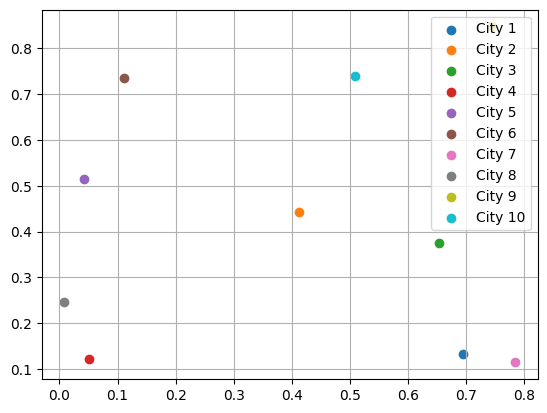

In [3]:
c = np.random.rand(N, 2) # Generate random coordinates to each city

# --- Plot cities ---
for i in range(N):
    plt.scatter(c[i,0], c[i,1], label=f'City {i+1}')

plt.legend()
plt.grid()
plt.show()

In the next cell, a symmetric matrix $d\in\mathbb{R}^{N \times N}$ with Euclidean distances between cities ($d_{i,j} = \lVert c_i - c_j\rVert$) is created.

In [4]:
# -- Distances ---
d = np.zeros(shape=(N,N))
for i in range(N):
    for j in range(N):
        d[i,j] = np.linalg.norm(c[i,:] - c[j,:]) # Euclidean distance between c_i and c_j

In the next cell, a function that maps the index pairs $(i,p)$ of $x_(i,p)$ to a single index is defined. This function is used to transform the matrix of variables into a vector, and vice versa.

In [5]:
#The following function maps indexes of the 2D array of variables to indexes of the 1D array that is sent to DWave's cloud
x = lambda city, position: int(N*city + position) 

In the next cell, the QUBO matrix $Q\in\mathbb{R}^{N^2 \times N^2}$ is ​​generated. Note that the matrix is ​​represented by a dictionary that maps pairs of indices to the respective elements.

In [6]:
# --- Generate the QUBO matrix ---
gamma = 100.0 # Penalty factor

qubo = {(a,b):0 for a in range(N**2) for b in range(N**2) if b >= a} # QUBO matrix as a dict

st = lambda a, b: (a, b) if a <= b else (b, a) # returns a sorted 2-uple

# -- Main term --
for p in range(1, N):
    for i in range(N):
        for j in range(N):
            if i != j:
                qubo[st(x(i,p), x(j,p-1))] += d[i,j]

for i in range(N):
    for j in range(N):
        if i != j:
            qubo[st(x(i,0), x(j,N-1))] += d[i,j]

# -- H1 term --
for i in range(N):
    for p in range(N):
        for q in range(N):
            qubo[st(x(i,p), x(i,q))] += gamma


for i in range(N):
    for p in range(N):
        qubo[st(x(i,p), x(i,p))] -= 2*gamma

# -- H2 term --
for p in range(N):
    for i in range(N):
        for j in range(N):
            qubo[st(x(i,p), x(j,p))] += gamma


for i in range(N):
    for p in range(N):
        qubo[st(x(i,p), x(i,p))] -= 2*gamma

In the next cell, the QUBO instance is sent to the DWave cloud. The solution obtained is assigned to the variable ``x_star`` ($x^*$).

In [7]:
# --- Solve QUBO with DWave's Hybrid Optimizer ---
sampler = LeapHybridSampler(token=getpass('Leap Token: '))
#sampler = SimulatedAnnealingSampler() # Uncomment this to use ocean's simulated annealing instead of the hybrid optimizer
bqm = dimod.BQM.from_qubo(qubo)
sample_set = sampler.sample(bqm)
x_star = sample_set.record[0][0].astype(int) # Solution as a 1D array of variables
x_star

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

Since the array in ``x_star`` is 1D, and $x^*$ is mathematically defined as a matrix, post-processing is necessary. In the following cells, this post-processing is done, and finally, the path $P$ is obtained following the rule $P_p = \max_{0 \leq i \leq N} x_{(i,p)}$.

In [8]:
# --- Solution post-processing ---
x_star = np.vstack([[x_star[x(i,p)] for i in range(N)] for p in range(N)]) # Transform the 1D array of variables into a 2D array where each row is a position in P
x_star


array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [9]:
P = [int(np.argmax(row)) for row in x_star] # Transform rows of binary variables into cities indexes
P

[3, 7, 4, 0, 6, 2, 8, 9, 1, 5]

In the next cells, the total distance of the obtained path is calculated, and the path is plotted.

In [10]:
# --- Calculation of total travel distance ---
total = sum([d[P[i], P[i+1]] for i in range(N-1)]) + d[P[0], P[N-1]]
print('Total distance:', float(total))

Total distance: 3.628153518878232


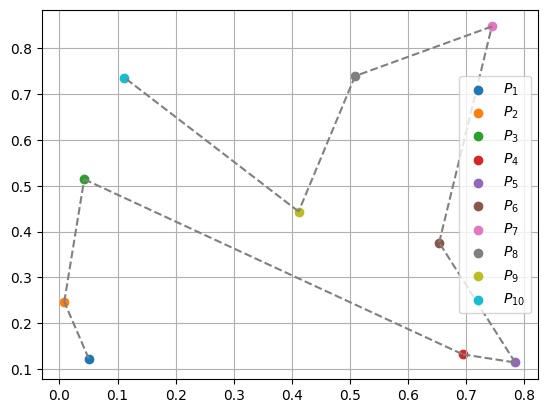

In [11]:
# --- Solution plot ---
for i in range(N-1):
    plt.plot(c[P[i:i+2],0], c[P[i:i+2],1], color='gray', linestyle='dashed')

for i in range(N):
    plt.scatter(c[P[i],0], c[P[i],1], label=f'$P_{{{i+1}}}$')

plt.legend()
plt.grid()
plt.show()